In [1]:
from load import load_eeg
import numpy as np
from antropy import lziv_complexity
import pandas as pd
from tqdm.notebook import trange
from joblib import Parallel, delayed
from matplotlib import pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\pthoe\miniforge3\envs\gen\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\pthoe\miniforge3\envs\gen\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\pthoe\miniforge3\envs\gen\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\pthoe\miniforge3\envs\gen\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  Fil

AttributeError: _ARRAY_API not found

In [2]:
BANDPASS = (1, 40)
NOTCH = None

rawp = load_eeg("second", "patient", bandpass=BANDPASS, notch=NOTCH)
rawc = load_eeg("second", "curandero", bandpass=BANDPASS, notch=NOTCH)

# keep only data after ingestion
ingestion_time = rawc.annotations.onset[np.where(rawc.annotations.description == "4")[0][0]]
rawc.crop(tmin=ingestion_time)
rawp.crop(tmin=ingestion_time)

# select EEG channels
rawc.pick("eeg")
rawp.pick("eeg")

print("\n\n====================================")
total_hours = len(rawc.times) / rawc.info['sfreq'] / 60 / 60
print(f"Loaded {total_hours:.2f} hours of {len(rawc.ch_names)}-channel EEG data from curandero and patient each.")
print("====================================")

Extracting EDF parameters from C:\Users\pthoe\projects\mexico\ceremony2\Gabi\EEG\session2_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Trigger has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
144 events found on stim channel Trigger
Event IDs: [1 2 3 4 5 6]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff fr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    2.7s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    3.2s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    3.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    3.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.8s finished


Extracting EDF parameters from C:\Users\pthoe\projects\mexico\ceremony2\Hugo\session2_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12599  =      0.000 ...    41.997 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Trigger has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
4 events found on stim channel Trigger
Event IDs: [1]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\analysis\load.py:43: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  [mne.io.read_raw_edf(join(expanduser(DATA_BASE), path)) for path in paths]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    1.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.0s finished


IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
def sliding_window(raw, func, window_seconds, step_seconds, n_jobs=-1):
    data = raw.get_data()
    sfreq = raw.info["sfreq"]
    window = int(window_seconds * sfreq)
    step = int(step_seconds * sfreq)
    results = Parallel(n_jobs=n_jobs)(
        delayed(func)(data[:, i:i+window]) for i in trange(0, data.shape[1] - window, step)
    )
    times = np.arange(0, len(data[0]) - window, step) / sfreq
    return times, np.stack(results, axis=1)

def lzc(x, normalize=True, axis=-1):
    x = x > np.median(x, axis=axis, keepdims=True)
    return np.apply_along_axis(lziv_complexity, axis, x, normalize=normalize)

t, outc = sliding_window(rawc, lzc, 60, 30)
t, outp = sliding_window(rawp, lzc, 60, 30)

t /= 60 * 60

  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/586 [00:00<?, ?it/s]

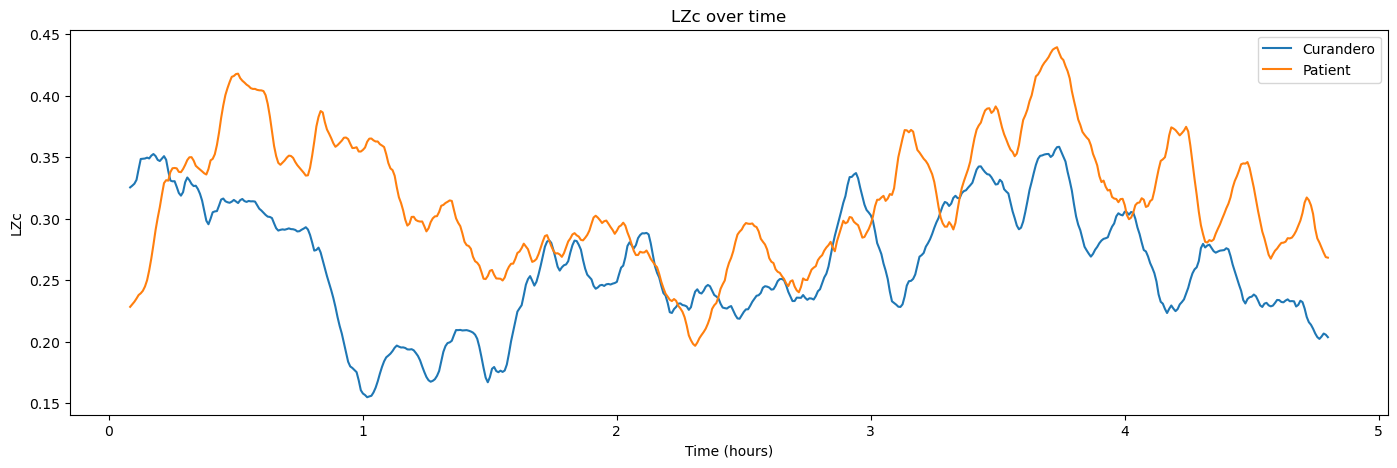

In [4]:
def smooth(x, window=20):
    return pd.Series(x).rolling(window=window, center=True).mean().values

plt.figure(figsize=(17, 5))
plt.title("LZc over time")
plt.plot(t, smooth(np.mean(outc, axis=0)), label="Curandero")
plt.plot(t, smooth(np.mean(outp, axis=0)), label="Patient")

# times = rawc.annotations.onset / 60 / 60
# times = times - times[0]
# for time in times[rawc.annotations.description == "5"]: # songs
#     plt.axvline(time, color="black", linestyle="--", linewidth=0.5)

plt.xlabel("Time (hours)")
plt.ylabel("LZc")
plt.legend()
plt.show()

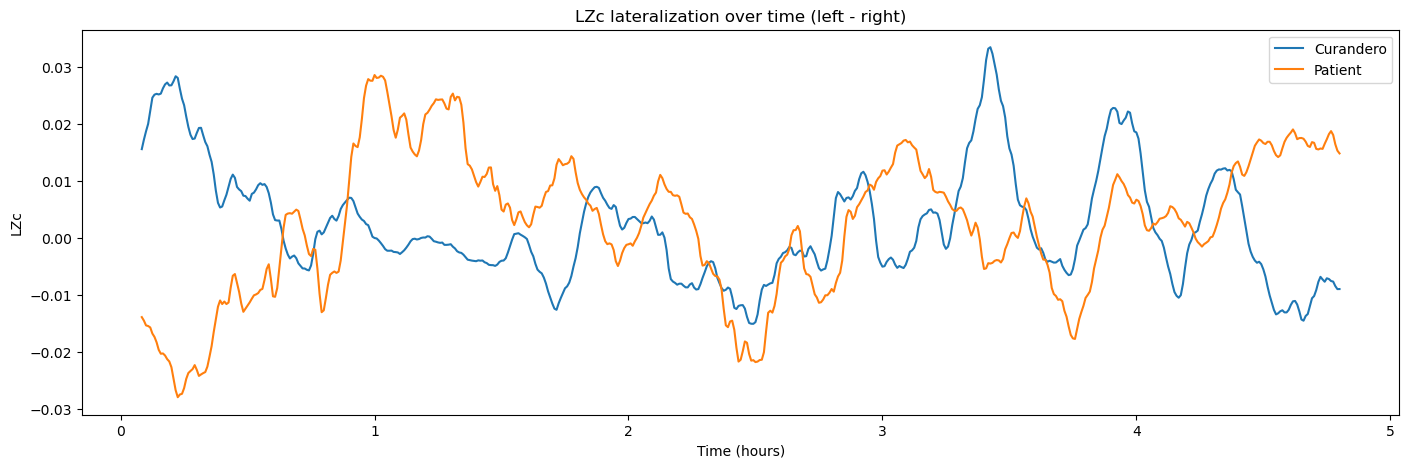

In [5]:
lchans = list(filter(lambda ch: ch[-1] != "z" and int(ch[-1]) % 2 == 1, rawc.ch_names))
lidxs = [rawc.ch_names.index(ch) for ch in lchans]

rchans = list(filter(lambda ch: ch[-1] != "z" and int(ch[-1]) % 2 == 0, rawc.ch_names))
ridxs = [rawc.ch_names.index(ch) for ch in rchans]

plt.figure(figsize=(17, 5))
plt.title("LZc lateralization over time (left - right)")
plt.plot(t, smooth(outc[lidxs].mean(axis=0) - outc[ridxs].mean(axis=0)), label="Curandero")
plt.plot(t, smooth(outp[lidxs].mean(axis=0) - outp[ridxs].mean(axis=0)), label="Patient")

# times = rawc.annotations.onset / 60 / 60
# times = times - times[0]
# for time in times[rawc.annotations.description == "5"]: # songs
#     plt.axvline(time, color="black", linestyle="--", linewidth=0.5)

plt.xlabel("Time (hours)")
plt.ylabel("LZc")
plt.legend()
plt.show()

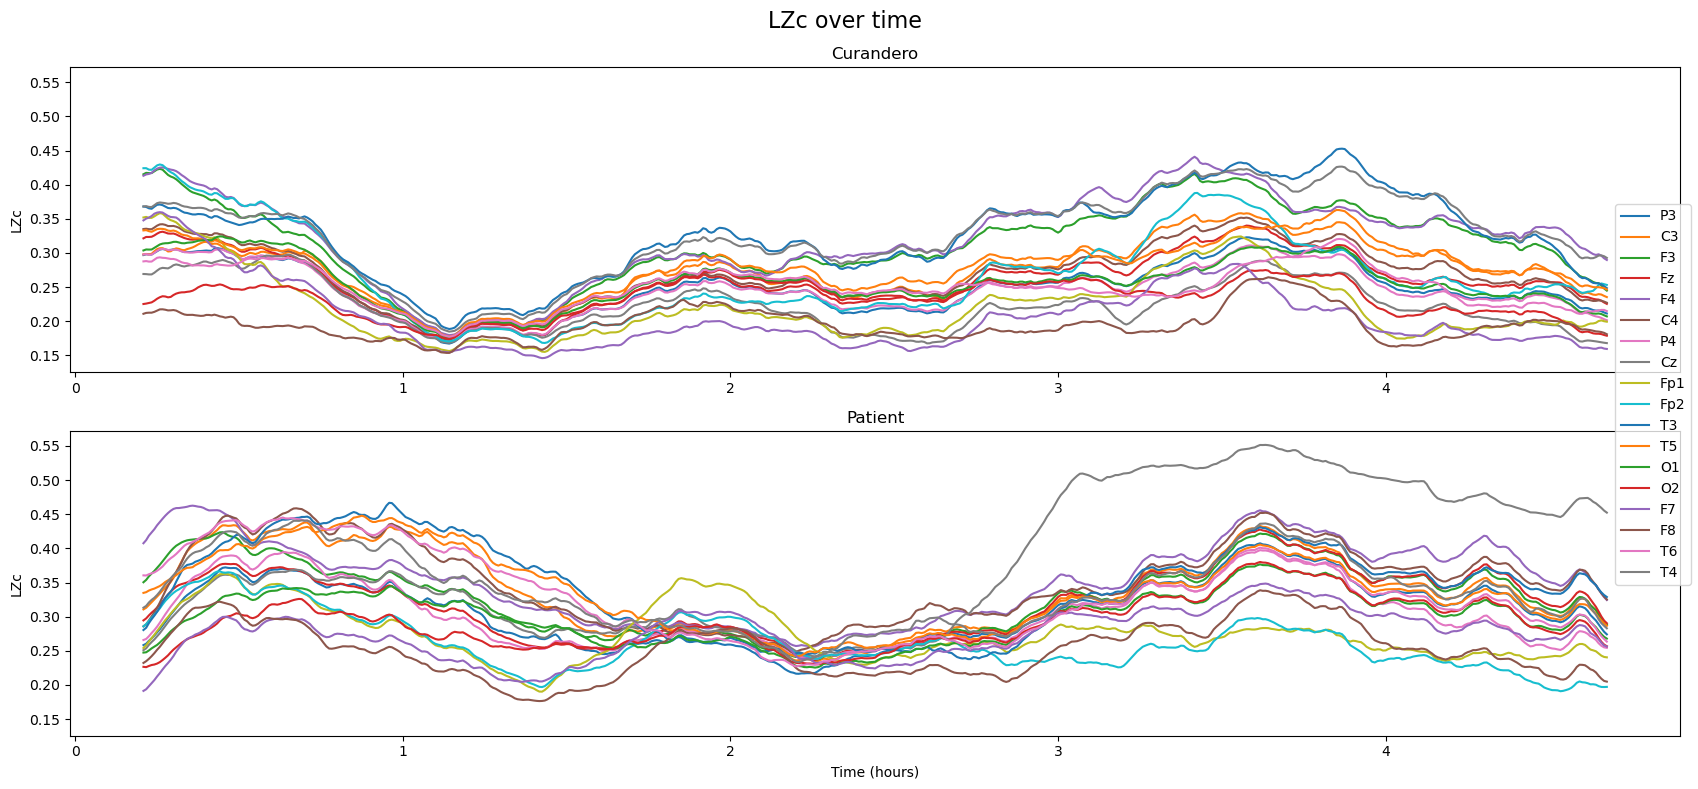

In [6]:
def smooth(x, window=50):
    return pd.Series(x).rolling(window=window, center=True).mean().values

plt.figure(figsize=(17, 8))
plt.suptitle("LZc over time", fontsize=16)

plt.subplot(2, 1, 1)
plt.title("Curandero")
plt.plot(t, np.array([smooth(ch) for ch in outc]).T, label=rawc.ch_names)
plt.ylabel("LZc")

plt.subplot(2, 1, 2, sharex=plt.gca(), sharey=plt.gca())
plt.title("Patient")
plt.plot(t, np.array([smooth(ch) for ch in outp]).T)
plt.ylabel("LZc")

plt.xlabel("Time (hours)")
plt.gcf().legend(loc="center right")
plt.tight_layout()
plt.show()